### Empirical Example for RobustiPY (Type 1)!

#### This example is designed to show how basic functionality -- such as OLS can be used with a cross-sectional dataset -- works.

In [1]:
import requests
import zipfile
import io
import os
import pandas as pd
import statsmodels.formula.api as smf
from robustipy.models import OLSRobust

import warnings
from robustipy.prototypes import MissingValueWarning

# Ignore all MissingValueWarning warnings from robustipy
warnings.filterwarnings(
    action="ignore",
    category=MissingValueWarning,
    module=r"robustipy\.prototypes"
)



Download the maketable2.zip from Dropbox:

In [2]:
url = "https://www.dropbox.com/s/1s1yb7a3hkjwzjh/maketable2.zip?dl=1"
response = requests.get(url)
response.raise_for_status()

Unzip into a local 'data' directory:

In [3]:
os.makedirs('../data/acemoglu_example', exist_ok=True)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall('../data/acemoglu_example')

Load the Stata file:

In [4]:
df = pd.read_stata('../data/acemoglu_example/maketable2.dta')

Define a helper to run and display OLS with robust SEs:

In [5]:
def run_regression(formula, data, label):
    model = smf.ols(formula, data=data).fit(cov_type='HC1')
    print(f"\n--- Column {label} ---")
    print(model.summary())

Execute each column's regression:

In [6]:
run_regression('logpgp95 ~ avexpr', df, 1)
run_regression('logpgp95 ~ avexpr', df[df['baseco'] == 1], 2)
run_regression('logpgp95 ~ avexpr + lat_abst', df, 3)
run_regression('logpgp95 ~ avexpr + lat_abst + africa + asia + other', df, 4)
run_regression('logpgp95 ~ avexpr + lat_abst', df[df['baseco'] == 1], 5)
run_regression('logpgp95 ~ avexpr + lat_abst + africa + asia + other', df[df['baseco'] == 1], 6)
run_regression('loghjypl ~ avexpr', df, 7)
run_regression('loghjypl ~ avexpr', df[df['baseco'] == 1], 8)


--- Column 1 ---
                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     334.8
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           5.14e-35
Time:                        17:58:28   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6261      0.241  

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     53.79
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           1.57e-20
Time:                        17:58:29   Log-Likelihood:                -52.979
No. Observations:                  64   AIC:                             118.0
Df Residuals:                      58   BIC:                             130.9
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7367      0.389     14.735      0.0

Now do RobustiPy things:

In [7]:
acemoglu_robust = OLSRobust(y=['logpgp95'], x=['avexpr'], data=df)
acemoglu_robust.fit(controls=['lat_abst', 'africa', 'asia', 'other'],
                    draws=1000,
                    kfold=10,
                    seed=192735,
                    oos_metric='rmse',
                    threshold=1000000)

You haven’t specified the number of CPUs. Is 7 okay? (yes/no): yes


Output()

OLSRobust is running with n_cpu=7, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the rmse metric.
The target variable of interest is avexpr. Let's begin the calculations...


Get the results:

In [8]:
acemoglu_robust_results = acemoglu_robust.get_results()

Plot:

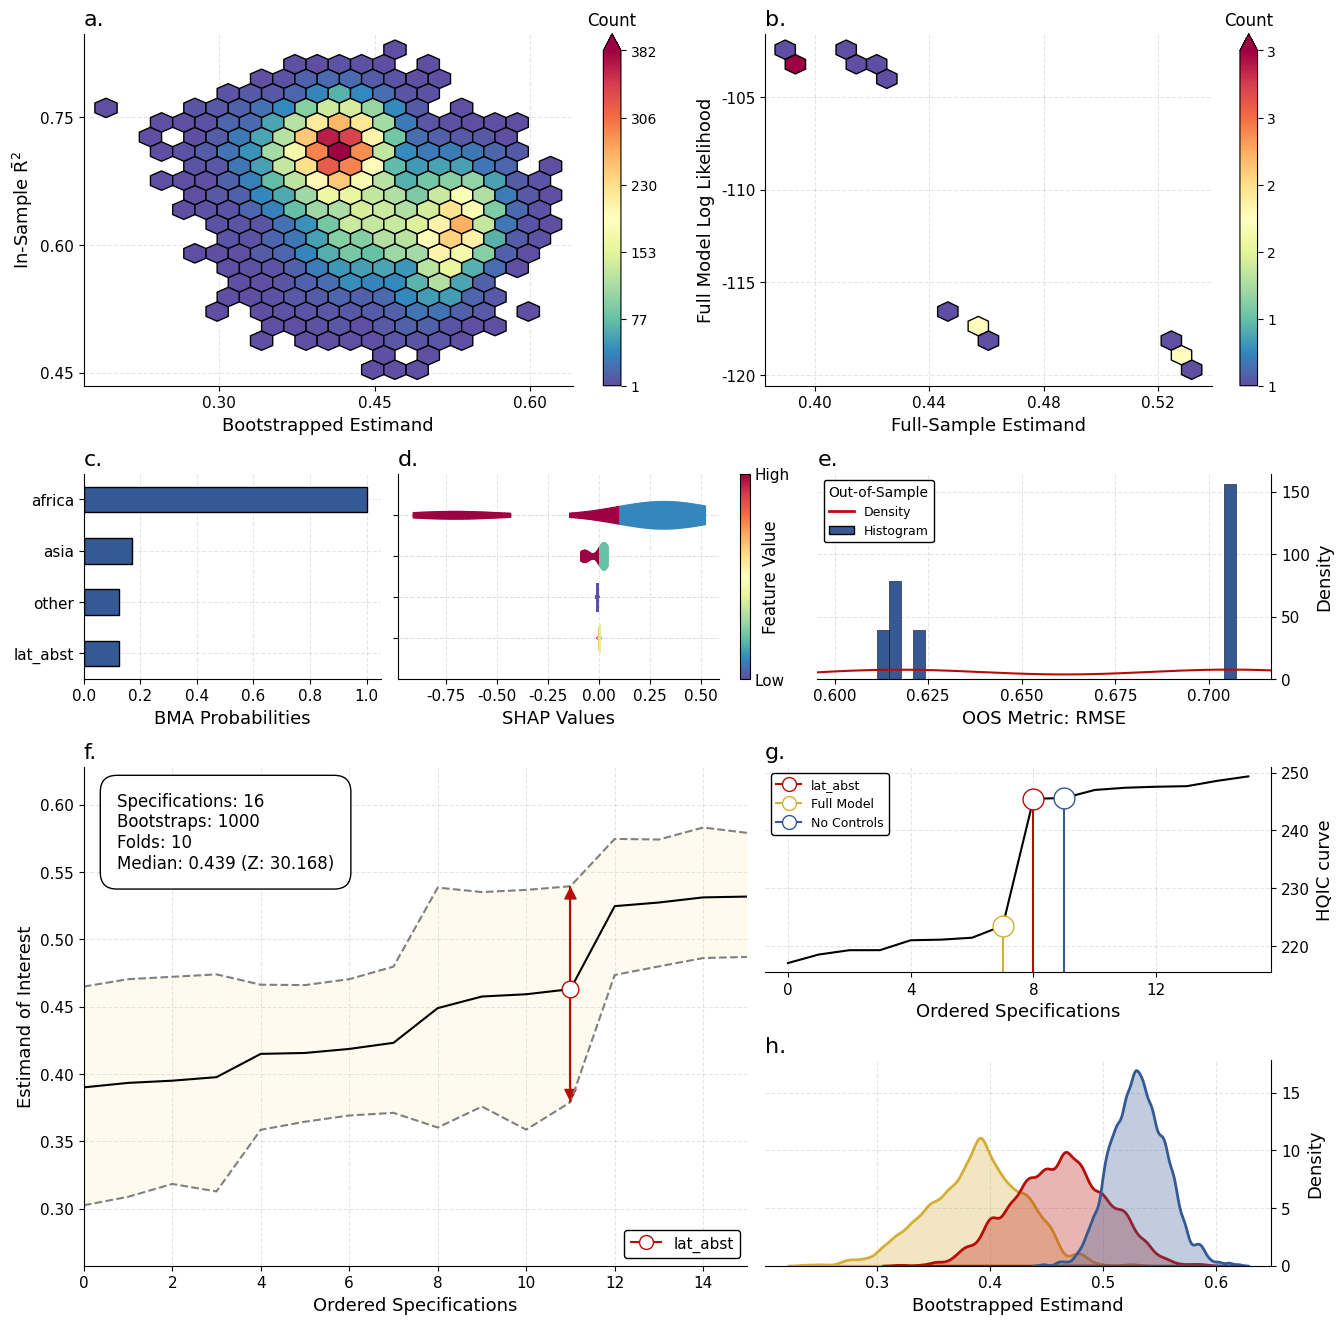

In [9]:
acemoglu_robust_results.plot(specs=[['lat_abst']],
                             ic='hqic',
                             ext='pdf',
                             ci=0.95,
                             loess=False,figpath = '../figures',
                             project_name='acemoglu_example',
                             figsize=(16, 16)
                            )

Summarize results:

In [10]:
acemoglu_robust_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: logpgp95
Independent variable: avexpr
Number of possible controls: 4
Number of draws: 1000
Number of folds: 10
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 0.44 (p-value: 0.0)
Median beta (all bootstraps and specifications): 0.44
Min beta (all specifications, no resampling): 0.39
Min beta (all bootstraps and specifications): 0.19
Max beta (all specifications, no resampling): 0.53
Max beta (all bootstraps and specifications): 0.62
AIC-weighted beta (all specifications, no resampling): 0.4
BIC-weighted beta (all specifications, no resampling): 0.42
HQIC-weighted beta (all specifications, no resampling): 0.41
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.0)
Significant portion of beta (all bootstraps and specifications): 1.0
Positive portion of beta (all specifications, no resampling): 1.0 (p-value:

Lets do this again, but now with a constant into the x-array.

In [11]:
df['constant'] = 1

In [12]:
acemoglu_robust_wc = OLSRobust(y=['logpgp95'], x=['avexpr'], data=df)
acemoglu_robust_wc.fit(controls=['lat_abst', 'africa', 'asia', 'other', 'constant'],
                    draws=1000,
                    kfold=10,
                    seed=192735,
                    oos_metric='rmse',
                    threshold=1000000)

You haven’t specified the number of CPUs. Is 7 okay? (yes/no): yes


Output()

OLSRobust is running with n_cpu=7, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the rmse metric.
The target variable of interest is avexpr. Let's begin the calculations...


In [13]:
acemoglu_robust_wc_results = acemoglu_robust_wc.get_results()

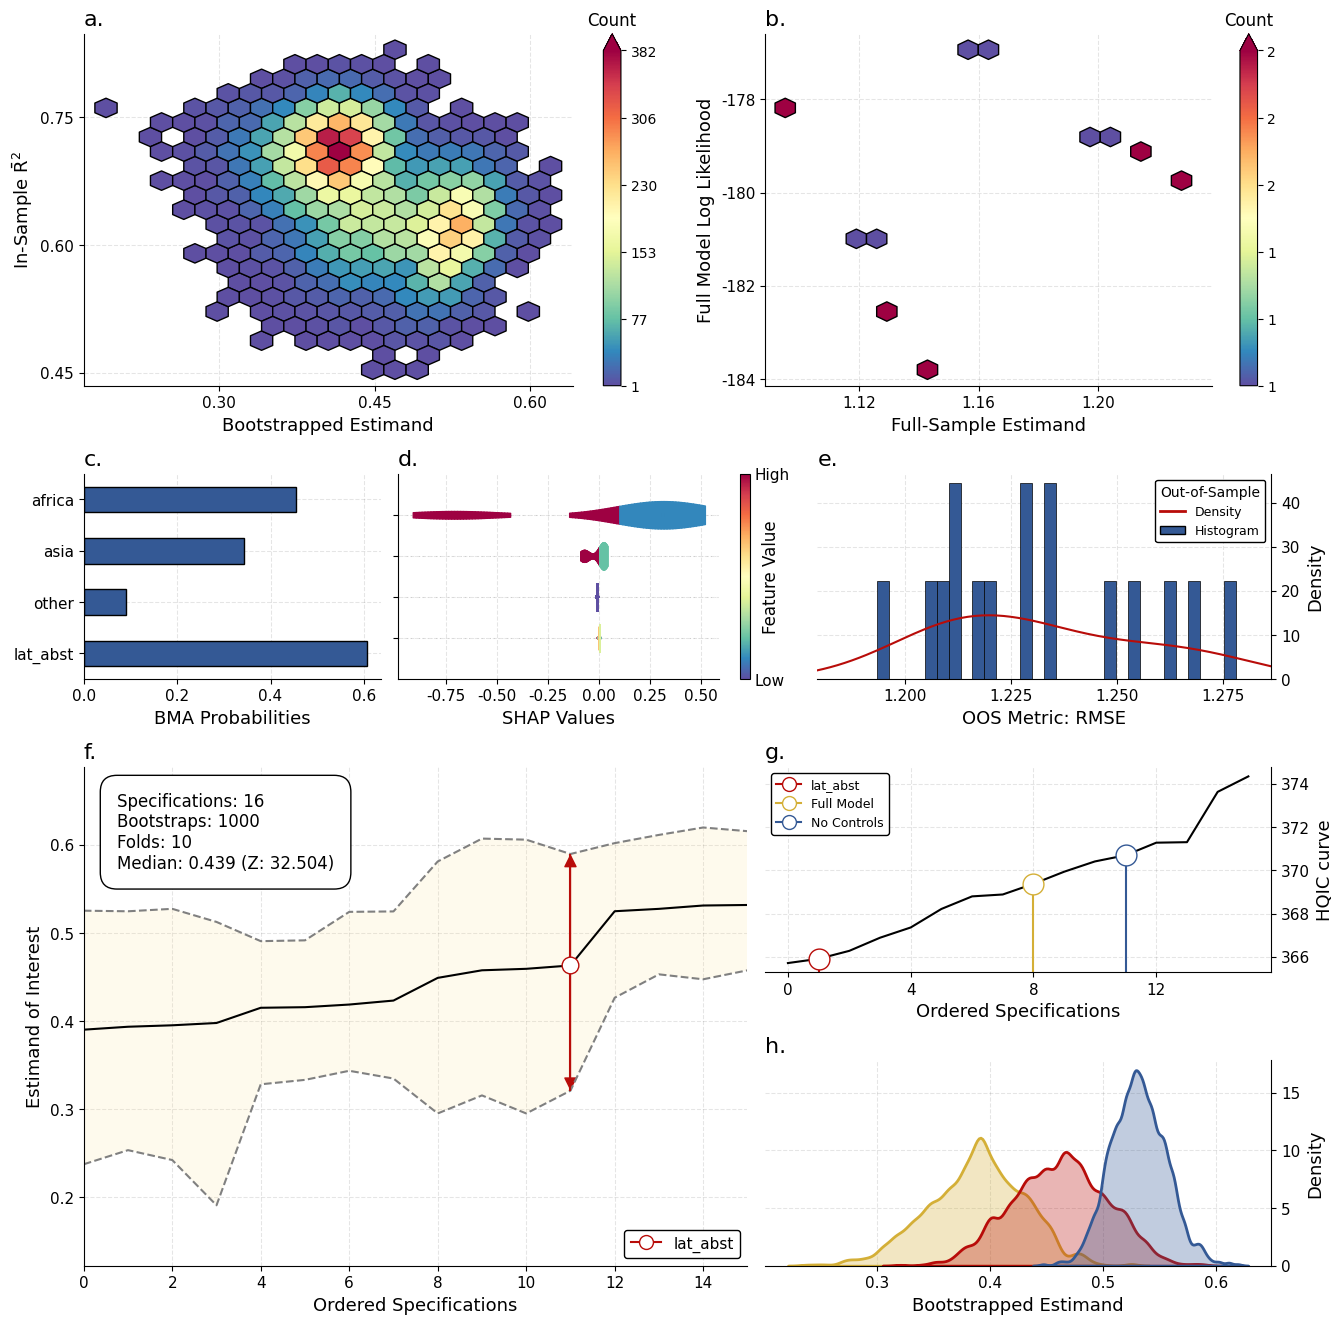

In [14]:
acemoglu_robust_wc_results.plot(specs=[['lat_abst']],
                                ic='hqic',
                                ext='pdf',
                                ci=1,
                                loess=False,
                                figpath = '../figures',
                                project_name='acemoglu_example_w_variable_constant',
                                figsize=(16, 16)
                               )

In [15]:
acemoglu_robust_wc_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: logpgp95
Independent variable: avexpr
Number of possible controls: 4
Number of draws: 1000
Number of folds: 10
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 1.15 (p-value: 0.0)
Median beta (all bootstraps and specifications): 0.44
Min beta (all specifications, no resampling): 1.1
Min beta (all bootstraps and specifications): 0.19
Max beta (all specifications, no resampling): 1.23
Max beta (all bootstraps and specifications): 0.62
AIC-weighted beta (all specifications, no resampling): 1.16
BIC-weighted beta (all specifications, no resampling): 1.18
HQIC-weighted beta (all specifications, no resampling): 1.17
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.0)
Significant portion of beta (all bootstraps and specifications): 1.0
Positive portion of beta (all specifications, no resampling): 1.0 (p-value: